# 5.1 Bayesian Logistic Regression on Synthetic Data

Consider the Bayesian logistic regression model
\begin{equation*}
p_\theta(x) = \mathcal{N}(x; \theta, \sigma^2 I_{d_x}), \qquad p(y|x) = \prod_{j=1}^{d_y} s(v_j^\intercal x)^{y_j} (1-s(v_j^\intercal x))^{1-y_j}.
\end{equation*}
Here $s(u)=e^u/(1+e^u)$ is the logistic function and $v_j$, $j\in[d_y]$ are the set of $d_x$-dimensional covariates with corresponding responses $y_j\in\{0,1\}$. $\sigma$ is given and fixed throughout. We generate a synthetic set of covariates, $\{v_j\}_{j=1}^{d_y}\subset \mathbb{R}^{d_x}$, from which are simulated a synthetic set of observations $y_j|\bar{\theta}_\star, x, v_j$, for fixed $\bar{\theta}_\star$, via a Bernoulli random variable with probability $s(v_j^\intercal x)$. The algorithm is tested on the recovery of this value of $\bar{\theta}_\star$. 

## Setup

We begin by importing the required modules,

In [1]:
import numpy as np
from KIPLMC.KIPLMC import KIPLMC1, KIPLMC2
from KIPLMC.baselines import MPGD, IPLA
from plotting import multiPlotter
from functools import partial
from KIPLMC.models import NormalModel

We set our fixed parameters and generate the artificial dataset.

In [2]:
h = 5e-3  # Step-size.
K = 2000  # Number of steps.
D = 50  # Dimension of latent space.
g = 2  # 1.2

y = np.random.normal(0, 1, (D, 1)) + np.random.normal(1, 1, (D, 1))

## Run Model and Plot
We will be plotting both Fig. 1 and Fig. 2. We will begin with Fig. 1 where we show a comparison for different solutions to a synthetic dataset. In Fig. 2 we make a comparison over different iterations to compare accuracy and variance.

### Fig. 1
We now initialise a collection of models to test,

In [3]:
models = {'MPGD': partial(MPGD, g=g, h=h, D=D, model=NormalModel()),
          'KIPLMC1': partial(KIPLMC1, g=g, h=h, D=D, model=NormalModel()),
          'KIPLMC2': partial(KIPLMC2, g=g, h=h, D=D, model=NormalModel())
          }

and run the models for different means and particle numbers,

In [4]:
plot = dict()
data = dict()

shape = (3, 3)
plots = dict()

for N in [5, 25, 125]:   # range of particle numbers
    for i in range(3):
        idx = ' ' * (i + 1) * N if i != 1 else f'N={N}'
        y_ = y + i    # change in dataset
        pl = dict()
        for label, model in models.items():
            model = model(N=N)
            pl[label] = model.run(K, l=y_)[0].squeeze()
        plots[idx] = pl


Then plot,

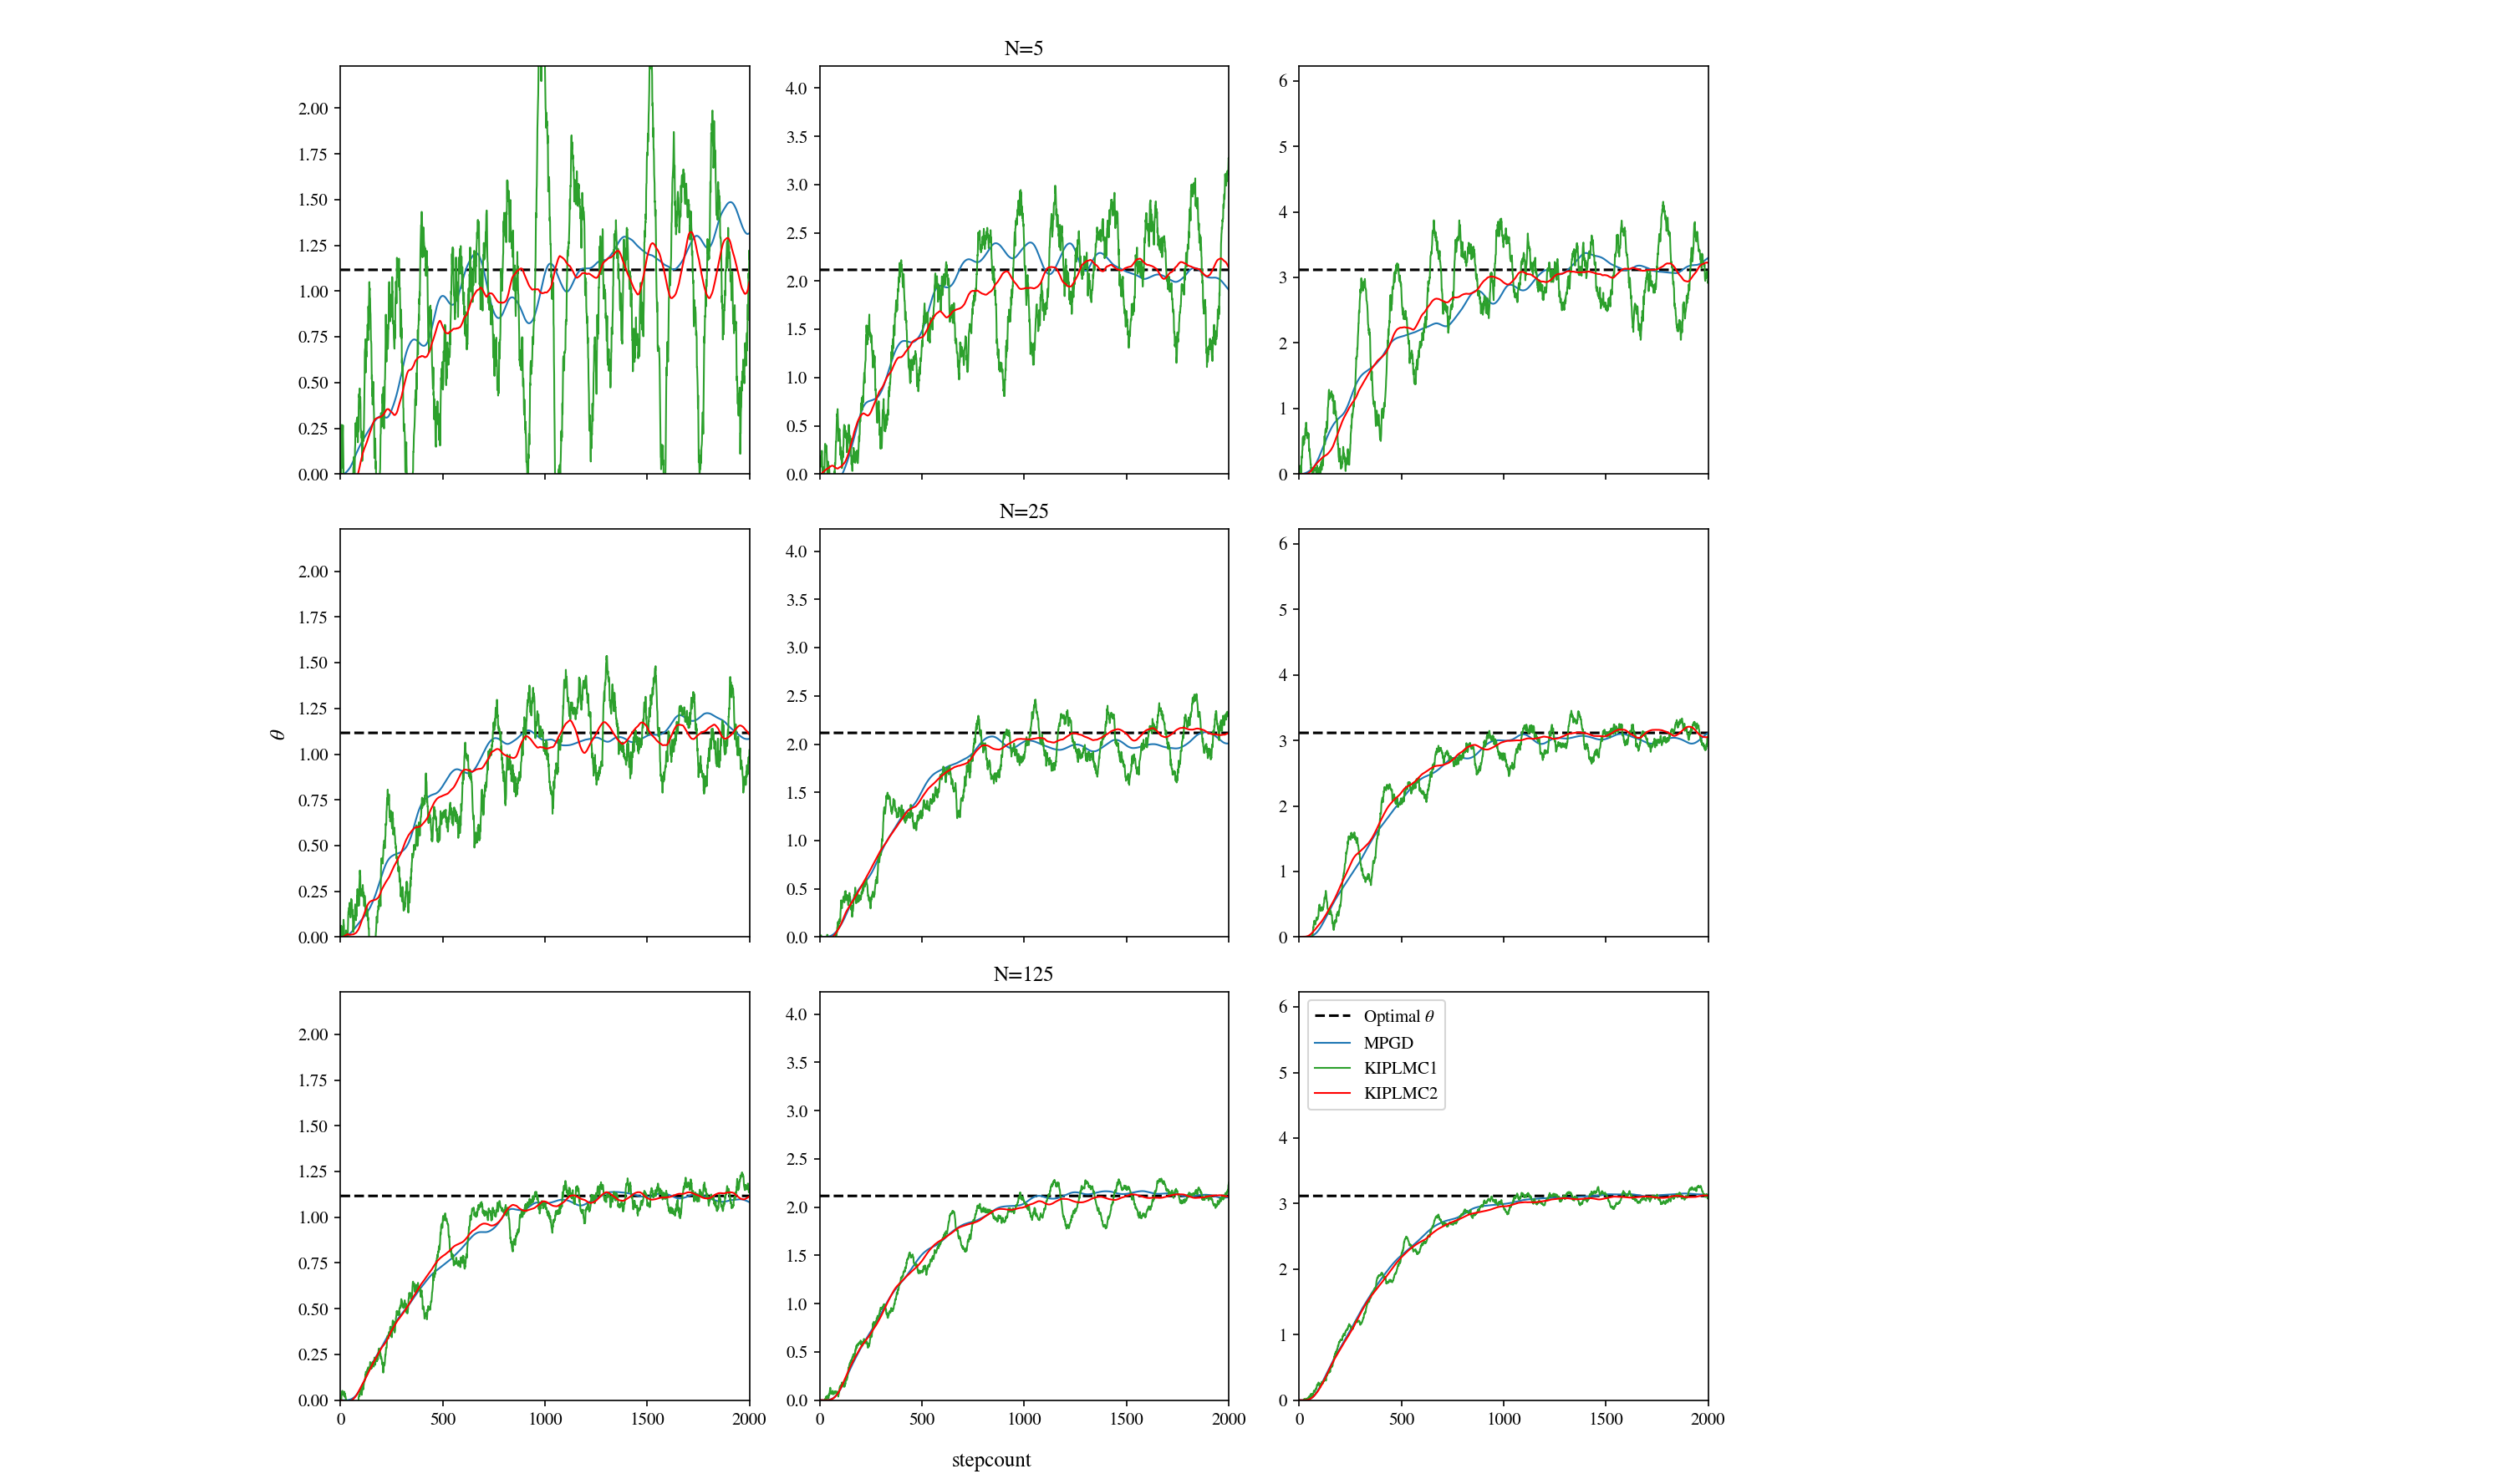

In [5]:
multiPlotter(plots, K, y=y, shape=shape).plot(r'$\theta$', 'stepcount')

### Fig. 2
Below we will run two different scripts to achieve the plots made in Fig. 2. The first script will run the model and plot the variance of the likelihood for different values of $N$. The second script will plot the ABC comparison between the models for a variety of $\gamma$, $\eta$ and $N$ values.

#### Comparison of Variance (Fig. 2 (b))
We now initialise a collection of models to test,

In [8]:
models = {'MPGD': partial(MPGD, g=g, h=h, D=D, model=NormalModel()),
          'KIPLMC1': partial(KIPLMC1, g=g, h=h, D=D, model=NormalModel()),
          'KIPLMC2': partial(KIPLMC2, g=g, h=h, D=D, model=NormalModel())
          }

plot = dict()

for label, _ in models.items():
    plot[label] = []

rng = [10, 50, 100, 500]   # range of N values

Run the models,

In [10]:
for N in rng:
    for label, model in models.items():
        model = model(N=N)
        plot[label].append(np.mean([np.var(model.run(K, l=y)[0][-500:]) for i in range(20)]))

Plot,

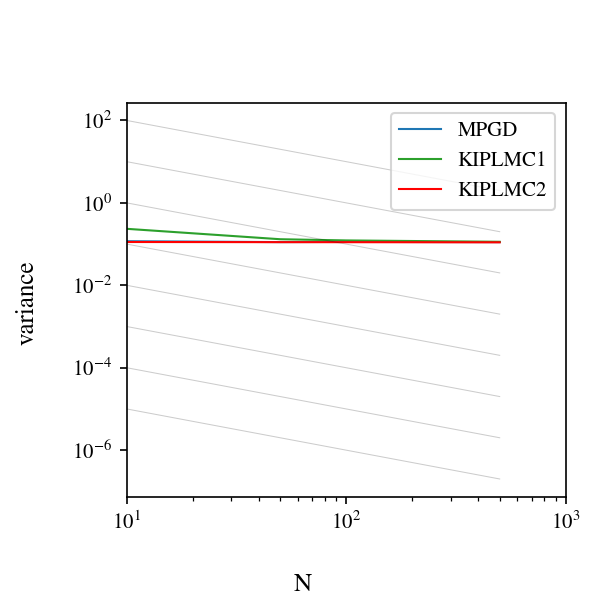

In [11]:
plots = {' ': plot}

multiPlotter(plots, 1000).plot('variance', 'N', log=True, xvals=rng)

#### Comparison of ABC (Fig. 2 (a))
We initialise the models to compare and define the ranges over which to compare them,

In [17]:
models = {'MPGD': partial(MPGD, N=N, D=D, model=NormalModel()),
          'KIPLMC2': partial(KIPLMC2, N=N, D=D, model=NormalModel())
          }

g = [0.25, 0.5, 1, 2, 4]
h = [1e-2, 2e-2, 3e-2, 5e-2, 6e-2, 7e-2]

We employ the ABC (Area Between the Curves) to compare the algorithms. Consider $c^k:\mathbb{N}\to \mathbb{R}$ and $c^m:\mathbb{N}\to \mathbb{R}$ to be the accuracy curves of KIPLMC2 and MPGDnc respectively, i.e. for $\{\theta_n\}_{n=1}^\infty$ generated by the KIPLMC2 algorithm, $c^k(n)=\|\theta_n -\bar{\theta}^\star\|$. The ABC we will compute is,
\[\sum_{i=1}^M w(i) (c^m(i)-c^k(i)),\]
where $M$ is the total number of time-steps and $w$ acts as a normalising, weighting function. We set $w(i)=\frac{2}{M(M+1)} \frac{i}{M}$ for our computations. Hence, the ABC computes a signed, weighted area between the error curves of MPGD and KIPLMC2. In particular, when $c^m$ is dominated by $c^k$, the ABC is negative, whilst positive in the converse case.

In [13]:
def abc(th_1, th_2, th_star, K):
    w = 2 / (K + K ** 2) * np.arange(K)
    c_1 = np.abs(th_1 - th_star)
    c_2 = np.abs(th_2 - th_star)
    return np.sum(w * (c_1 - c_2))

Run the models

In [18]:
hp = np.zeros((len(g), len(h)))
it = np.nditer(hp, flags=['multi_index'])

for x in it:
    i, j = it.multi_index
    g_ = g[i]
    h_ = h[j]

    th_1 = models['MPGD'](g=g_, h=h_).run(K=K, l=y)[0][-1]
    th_2 = models['KIPLMC2'](g=g_, h=h_).run(K=K, l=y)[0][-1]
    
    hp[i, j] = abc(th_1, th_2, np.mean(y), K+1)

and plot the results.

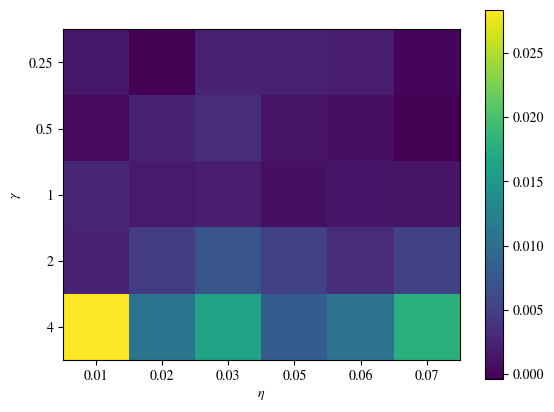

In [19]:
import matplotlib.pyplot as plt

plt.imshow(hp)
plt.yticks(ticks=np.arange(len(g)), labels=g)
plt.ylabel('$\gamma$')
plt.xticks(ticks=np.arange(len(h)), labels=h)
plt.xlabel('$\eta$')
plt.colorbar()
plt.show()